In [1]:
import argparse
import os
import random
import shutil
import time
import warnings

import torch
import numpy as np
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torch.utils.data.distributed
import torchvision.transforms as transforms
import torchvision.datasets as datasets

from kymatio import Scattering2D
from phase_scattering2d_torch import ScatteringTorch2D_wph
from models.ISTC import ISTC
from models.Rescaling import Rescaling
from models.LinearProj import LinearProj
from models.Classifier import Classifier
from models.SparseScatNet import SparseScatNet

from torch.utils.tensorboard import SummaryWriter
from utils import print_and_write, compute_stding_matrix

import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
from tensorboard import notebook
#notebook.list()

In [3]:
#notebook.display(port=6008, height=1000)

# GPU or CPU

In [4]:
use_gpu = torch.cuda.is_available()
if use_gpu:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Define the model based on the different parameteres 

## Model parameters : based on the parser

# Load the saved model

In [5]:
! ls 

LICENSE
README.md
__pycache__
checkpoints
checkpoints_sparsescatnet
checkpoints_sparsescatnet_100_class
checkpoints_sparsescatnet_100_class_dict_save
checkpoints_sparsescatnet_10_class
checkpoints_sparsescatnet_16
checkpoints_sparsescatnet_30_class
cmd.txt
convergence_analysis.ipynb
convergence_analysis.py
main.py
model_analysis.ipynb
models
phase_scattering2d_torch.py
run_from_cluster.ipynb
sparsescatnet_logs
sparsescatnet_logs_100_class
sparsescatnet_logs_100_class_dict_save
sparsescatnet_logs_10_class
sparsescatnet_logs_16
sparsescatnet_logs_30_class
standardization
training_logs
utils.py
utils_sampling


In [6]:
! ls checkpoints_sparsescatnet_16

sparsescatnet_batchsize_256_lrfreq_60.pth.tar
sparsescatnet_batchsize_256_lrfreq_60_best.pth.tar


In [7]:
! ls checkpoints_sparsescatnet_30_class/

sparsescatnet_batchsize_256_lrfreq_60.pth.tar
sparsescatnet_batchsize_256_lrfreq_60_best.pth.tar


In [8]:
#model_path = "checkpoints_sparsescatnet_16/sparsescatnet_batchsize_256_lrfreq_60_best.pth.tar"
#model_path = "checkpoints_sparsescatnet_30_class/sparsescatnet_batchsize_256_lrfreq_60_best.pth.tar"
model_path = "checkpoints_sparsescatnet_100_class/sparsescatnet_batchsize_256_lrfreq_60_best.pth.tar"

In [9]:
loaded_dict = torch.load(model_path)

In [10]:
loaded_dict.keys()

dict_keys(['epoch', 'arch', 'state_dict', 'best_acc1', 'optimizer'])

In [11]:
loaded_dict["optimizer"].keys()

dict_keys(['state', 'param_groups'])

In [12]:
best_epoch = loaded_dict["epoch"]

In [13]:
loaded_dict["state_dict"].keys()

odict_keys(['module.scattering.0.tensor0', 'module.scattering.0.tensor1', 'module.scattering.0.tensor2', 'module.scattering.0.tensor3', 'module.scattering.0.tensor4', 'module.scattering.0.tensor5', 'module.scattering.0.tensor6', 'module.scattering.0.tensor7', 'module.scattering.0.tensor8', 'module.scattering.0.tensor9', 'module.scattering.0.tensor10', 'module.scattering.0.tensor11', 'module.scattering.0.tensor12', 'module.scattering.0.tensor13', 'module.scattering.0.tensor14', 'module.scattering.0.tensor15', 'module.scattering.0.tensor16', 'module.scattering.0.tensor17', 'module.scattering.0.tensor18', 'module.scattering.0.tensor19', 'module.scattering.0.tensor20', 'module.scattering.0.tensor21', 'module.scattering.0.tensor22', 'module.scattering.0.tensor23', 'module.scattering.0.tensor24', 'module.scattering.0.tensor25', 'module.scattering.0.tensor26', 'module.scattering.0.tensor27', 'module.scattering.0.tensor28', 'module.scattering.0.tensor29', 'module.scattering.0.tensor30', 'modul

## Let's analyse the weights of the dictionnary of ISTC

In [14]:
istc_dictionary_weight = loaded_dict["state_dict"]["module.istc.dictionary_weight"]

In [15]:
istc_dictionary_weight.size()

torch.Size([256, 2048, 1, 1])

##  convert the 4D tensor to a 2D tensor

In [16]:
istc_dictionary_weight = istc_dictionary_weight.view(istc_dictionary_weight.size()[0], 
                                                     istc_dictionary_weight.size()[1])

In [17]:
istc_dictionary_weight.size()

torch.Size([256, 2048])

In [18]:
istc_dictionary_weight[0].size()

torch.Size([2048])

## Visualisations of the dictionnary

In [19]:
dict_as_numpy = istc_dictionary_weight.cpu().numpy()

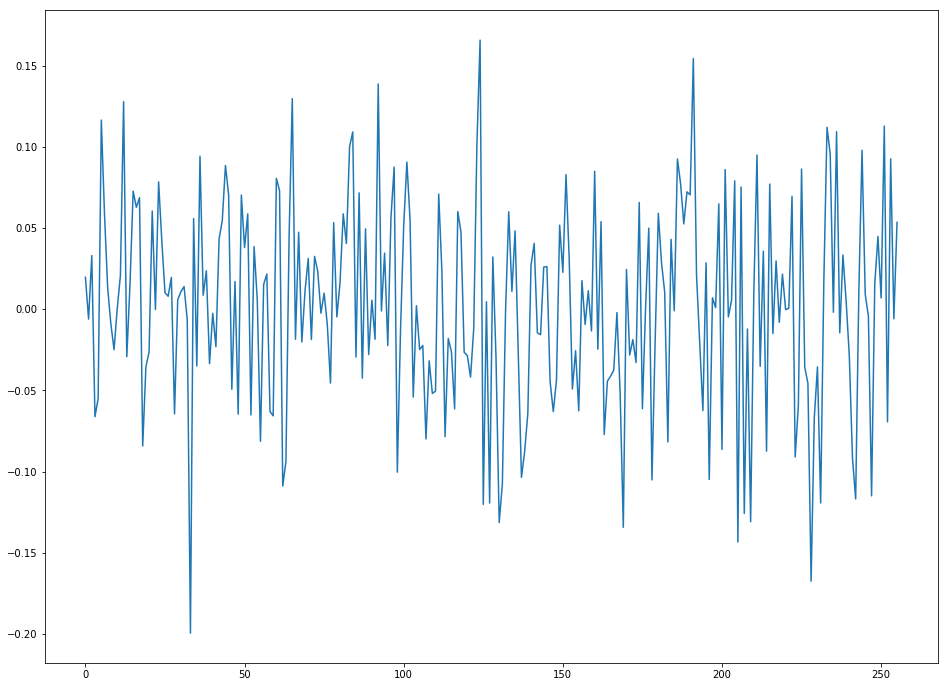

In [20]:
plt.figure(figsize=(16,12))
plt.plot(dict_as_numpy[:,0])
plt.show()

In [21]:
all_values = istc_dictionary_weight.view(-1).cpu().numpy()

In [22]:
all_values.shape

(524288,)

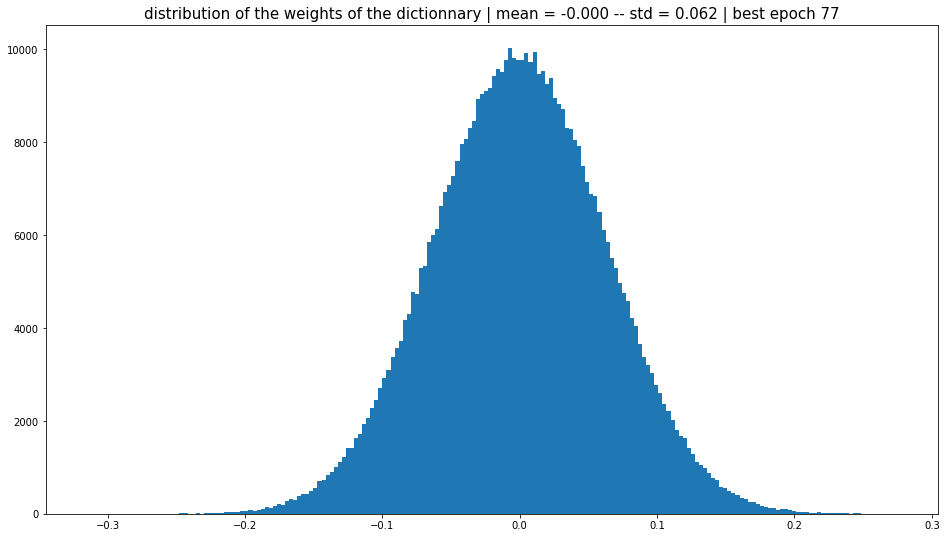

In [23]:
plt.figure(figsize=(16,9))
plt.hist(all_values, bins=200)
plt.title("distribution of the weights of the dictionnary | mean = {:.3f} -- std = {:.3f} | best epoch {}".format(np.mean(all_values), np.std(all_values), best_epoch), fontsize = 15)
plt.show()

# Results of every layer

In [24]:
## python3 main.py -a sparsescatnet -p 100 --scattering-J 4 --scattering-order2 --scattering-wph --L-kernel-size 3 --dictionary-size 2048 --L-proj-size 256 --epochs 20 --learning-rate-adjust-frequency 60 --lr 0.01 --lambda-star 0.05 --grad-lambda-star --lambda-star-lb 0.05 --l0-inf-init --epsilon-lambda-0 1 --logdir ./sparsescatnet_logs --n-iterations 12  --classifier-type mlp --nb-l-mlp 2 --dropout-p-mlp 0.3 --nb-hidden-units 4096 --avg-ker-size 3 --savedir ./checkpoints_sparsescatnet -j 10  ~/Datasets/ImageNet/ILSVRC/Data/CLS-LOC

In [25]:
model_names = ['sparsescatnet', 'sparsescatnetw', 'scatnet']

NEW_IMAGE_SIZE = 100

arch               = "sparsescatnet"
scattering_J       = 4
scattering_order2  = True
scat_angles        = 8
scattering_wph     = True
scattering_nphases = 4
nb_classes         = 100
L_proj_size        = 256
L_kernel_size      = 3
n_iterations       = 12
dictionary_size    = 2048
classifier_type    = "mlp"
lambda_0           = 0.3
lambda_star        = 0.05
lambda_star_lb     = 0.05
grad_lambda_star   = True
epsilon_lambda_0   = 1
output_rec         = False
nb_hidden_units    = 4096
nb_l_mlp           = 2
dropout_p_mlp      = 0.3
avg_ker_size       = 3
BS                 = 256
workers            = 10

## Model creation

In [26]:
if arch in model_names:
    n_space = NEW_IMAGE_SIZE
    nb_channels_in = 3

    # create scattering
    J = scattering_J
    L_ang = scat_angles

    max_order = 2 if scattering_order2 else 1

    if scattering_wph:
        A = scattering_nphases
        scattering = ScatteringTorch2D_wph(J=J, shape=(NEW_IMAGE_SIZE, NEW_IMAGE_SIZE), L=L_ang, A=A, 
                                           max_order=max_order)                                    
    else:
        scattering = Scattering2D(J=J, shape=(NEW_IMAGE_SIZE, NEW_IMAGE_SIZE), L=L_ang, 
                                  max_order=max_order)
    # Flatten scattering
    scattering = nn.Sequential(scattering, nn.Flatten(1, 2))

    if scattering_wph:
        nb_channels_in += 3 * A * L_ang * J
    else:
        nb_channels_in += 3 * L_ang * J

    if max_order == 2:
        nb_channels_in += 3 * (L_ang ** 2) * J * (J - 1) // 2

    n_space = n_space // (2 ** J)
###########################################################################################
    
    std_file = 'standardization/ImageNet2012_scattering_J{}_order{}_wph_{}_nphases_{}_nb_classes_{}.pth.tar'.format(
        scattering_J, 2 if scattering_order2 else 1, scattering_wph,
        scattering_nphases if scattering_wph else 0, nb_classes)

    # compute the mean and the std of the data
    if os.path.isfile(std_file):
        std_dict = torch.load(std_file)
        mean_std = std_dict['mean']
        stding_mat = std_dict['matrix']
    else:
        print("standirisation file not found")

    standardization = Rescaling(mean_std, stding_mat)
    
    if arch in ['sparsescatnet', 'sparsescatnetw']:
        proj = nn.Conv2d(nb_channels_in, L_proj_size, kernel_size=L_kernel_size, stride=1,
                         padding=0, bias=False)
        nb_channels_in = L_proj_size
        linear_proj = LinearProj(standardization, proj, L_kernel_size)
    else:  # scatnet
        proj = nn.Identity()
        linear_proj = LinearProj(standardization, proj, 0)

    ###########################################################################################

    # Create ISTC (when applicable)
    if arch in ['sparsescatnet', 'sparsescatnetw']:
    ###########################################################################################
        if arch == 'sparsescatnet':
            istc = ISTC(nb_channels_in, dictionary_size=dictionary_size, n_iterations=n_iterations,
                        lambda_0=lambda_0, lambda_star=lambda_star, lambda_star_lb=lambda_star_lb,
                        grad_lambda_star=grad_lambda_star, epsilon_lambda_0=epsilon_lambda_0,
                        output_rec=output_rec)

        elif arch == 'sparsescatnetw':
            istc = ISTC(nb_channels_in, dictionary_size=dictionary_size, n_iterations=n_iterations,
                        lambda_0=lambda_0, lambda_star=lambda_star, lambda_star_lb=lambda_star_lb,
                        grad_lambda_star=grad_lambda_star, epsilon_lambda_0=epsilon_lambda_0,
                        output_rec=output_rec, use_W=True)

        if not output_rec:
            nb_channels_in = dictionary_size

    elif arch == 'scatnet':
        print("=> creating model ScatNet with phase scattering {} and classifier {}".\
            format(scattering_wph, classifier_type))

    # Create classifier
    ###########################################################################################
    classifier = Classifier(n_space, nb_channels_in, classifier_type=classifier_type,
                            nb_classes=1000, nb_hidden_units=nb_hidden_units, nb_l_mlp=nb_l_mlp,
                            dropout_p_mlp=dropout_p_mlp, avg_ker_size=avg_ker_size)

    # Create model
    ###########################################################################################
    #model = SparseScatNet(scattering, linear_proj, istc, nn.Identity(), return_full_inf=False)
    if arch in ['sparsescatnet', 'sparsescatnetw']:
        model = SparseScatNet(scattering, linear_proj, istc, classifier, return_full_inf=True)  # print model info

    elif arch == 'scatnet':
        model = nn.Sequential(scattering, linear_proj, classifier)
else:
    print("not a valid model")

## Load the model

In [27]:
model_dict = model.state_dict()
checkpoint_dict = loaded_dict['state_dict']
checkpoint_dict = {k: v for k, v in checkpoint_dict.items() if k in model_dict}
model_dict.update(checkpoint_dict)
model.load_state_dict(model_dict)
dictionary = model.istc.dictionary_weight.data
w_matrix   = model.istc.w_weight.data

In [28]:
# model to GPU and enable eval mode
model.cuda()
model.eval()

SparseScatNet(
  (scattering): Sequential(
    (0): ScatteringTorch2D_wph()
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (linear_proj): LinearProj(
    (standardization): Rescaling()
    (proj): Conv2d(1539, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
  )
  (istc): ISTC()
  (classifier): Classifier(
    (bn): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (classifier): Sequential(
      (0): Linear(in_features=32768, out_features=4096, bias=True)
      (1): ReLU(inplace=True)
      (2): Dropout(p=0.3, inplace=False)
      (3): Linear(in_features=4096, out_features=4096, bias=True)
      (4): ReLU(inplace=True)
      (5): Dropout(p=0.3, inplace=False)
      (6): Linear(in_features=4096, out_features=1000, bias=True)
    )
  )
)

## Load data 

In [29]:
path_data = "~/Datasets/ImageNet/ILSVRC/Data/CLS-LOC"

valdir   = os.path.join(path_data, 'val')
    
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])

dataset = datasets.ImageFolder(valdir, transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.Resize((NEW_IMAGE_SIZE, NEW_IMAGE_SIZE)),
                    transforms.ToTensor(),
                    normalize,
                ]))

dataset = torch.utils.data.Subset(dataset, range(100))

In [30]:
loader  = torch.utils.data.DataLoader(dataset, batch_size=BS, shuffle=False, 
                                      num_workers=workers, pin_memory=True)

have the loader as a iterable list

In [31]:
iter_loader = next(iter(loader))[0]

In [32]:
len(iter_loader)

100

In [33]:
n_examples = 10
input_test = iter_loader[0:n_examples].cuda()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


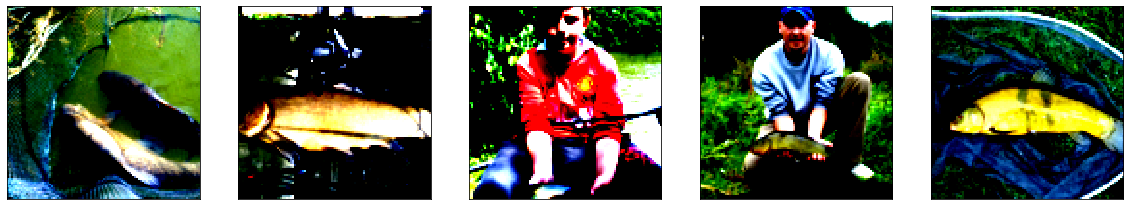

In [34]:
nsamples = 5
imgs, labels = next(iter(loader))

fig=plt.figure(figsize=(20,5),facecolor='w')
for i in range(nsamples):
    ax = plt.subplot(1,nsamples, i+1)
    plt.imshow(torch.transpose(torch.transpose(imgs[i, :, :, :], 0, 2), 0, 1), vmin=0, vmax=1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

### Scattering:

In [35]:
model.scattering

Sequential(
  (0): ScatteringTorch2D_wph()
  (1): Flatten(start_dim=1, end_dim=2)
)

In the case of 2D inputs data, and for an input tensor $(B,C,N_1,N_2)$, with $J = $scattering_J and $L = $scat_angles and $A = $scattering_nphases, the output tensor has the following dimension :



if scattering_order2 == False : 
$$ (B, C, 1 + LJ + \frac{L^{2}J(J-1)}{2}, \frac{N_1}{2^J}, \frac{N_2}{2^J})  $$

if scattering_order2 == True : 
$$ (B, C, 1 + ALJ + \frac{L^{2}J(J-1)}{2}, \frac{N_1}{2^J}, \frac{N_2}{2^J})  $$

In [36]:
print("-----------------------------")
print("variables values : ")
print(f"scattering_order2      = {scattering_order2}")
print(f"scattering_J       (J) = {scattering_J}")
print(f"scat_angles        (L) = {scat_angles}")
print(f"scattering_nphases (A) = {scattering_nphases}")
print("-----------------------------")
print(f"dimension of the inputs  : (B, {input_test[0].size()[0]}, {input_test[0].size()[1]}, {input_test[0].size()[2]})")
print()
dim_3 = 1 + 0.5*scattering_J*(scattering_J-1)*scat_angles**2
if scattering_order2 : 
    dim_3 += scattering_nphases*scat_angles*scattering_J
else : 
    dim_3 += scat_angles*scattering_J
dim_3 = int(dim_3)
print(f"dimension of the outputs : (B, {input_test[0].size()[0]}, {dim_3}, {input_test[0].size()[1]//2**scattering_J}, {input_test[0].size()[2]//2**scattering_J})")
print("-----------------------------")

-----------------------------
variables values : 
scattering_order2      = True
scattering_J       (J) = 4
scat_angles        (L) = 8
scattering_nphases (A) = 4
-----------------------------
dimension of the inputs  : (B, 3, 100, 100)

dimension of the outputs : (B, 3, 513, 6, 6)
-----------------------------


In [37]:
def draw_scattering_coef(img_array, scat_coef, J, L, A) :
    
    fig, ax = plt.subplots(figsize=(7,7)) 
    
    ## plot the image 
    ax.imshow(img_array, vmin=0, vmax=1)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)   
    
    ## plot the scattering coefficients
    norm = mpl.colors.Normalize(scat_coef.min(), scat_coef.max(), clip=True)
    mapper = cm.ScalarMappable(norm=norm, cmap="magma")  ## gray
    nb_coeffs, window_rows, window_columns = scat_coef.shape
    
    
    ax.axis('off')
    offset = 0.1
    for row in range(window_rows):
        for column in range(window_columns):
            ax=fig.add_subplot(window_rows, window_columns, 1 + column + row * window_rows, projection='polar')
            ax.set_ylim(0, 1)
            ax.axis('off')
            ax.set_yticklabels([])  # turn off radial tick labels (yticks)
            ax.set_xticklabels([])  # turn off degrees
            # ax.set_theta_zero_location('N')  # 0° to North
            coefficients = scat_coef[:, row, column]
            for j in range(J):
                for l in range(L):
                    coeff = coefficients[l + (J - 1 - j) * L]
                    color = mpl.colors.to_hex(mapper.to_rgba(coeff))
                    ax.bar(x=(4.5+l) *  np.pi / L,
                           height=2*(2**(j-1) / 2**J),
                           width=2 * np.pi / L,
                           bottom=offset + (2**j / 2**J) ,
                           color=color)
                    ax.bar(x=(4.5+l+L) * np.pi / L,
                           height=2*(2**(j-1) / 2**J),
                           width=2 * np.pi / L,
                           bottom=offset + (2**j / 2**J) ,
                           color=color)
    plt.show()

In [38]:
model.scattering[0](input_test).shape

/usr/users/gpusdi1/gpusdi1_22/.local/lib/python3.6/site-packages/kymatio/scattering2d/backend/torch_backend.py:231: UserWarning: The function torch.fft is deprecated and will be removed in PyTorch 1.8. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.fftn. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:567.)
  output = torch.fft(x, 2, normalized=False)
/usr/users/gpusdi1/gpusdi1_22/.local/lib/python3.6/site-packages/kymatio/scattering2d/backend/torch_backend.py:226: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:602.)
  output = torch.irfft(x, 2, normalized=False, onesided=False)
/usr/users/gpusdi1/gpusdi1_22/.local/lib/python3.6/site-packages/kymatio/scatteri

torch.Size([10, 3, 513, 6, 6])

In [39]:
scattering_coefficients = model.scattering[0](input_test).cpu().numpy()

## invert colors : 
scattering_coefficients = -scattering_coefficients

In [40]:
## skip the low pass filter 
scattering_coefficients = scattering_coefficients[:,:,1:,:,:]

In [41]:
scattering_coefficients.shape

(10, 3, 512, 6, 6)

 -- NOTE : since the images are in RGB (3 axis), the scattering rings plotted are the mean of the 3 axis !


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


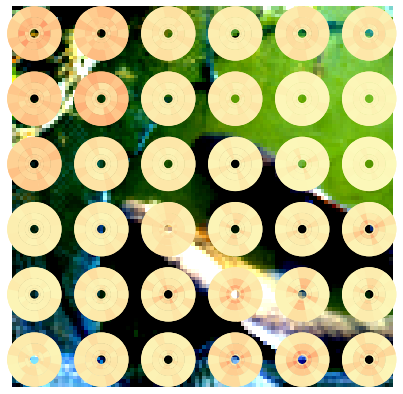

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


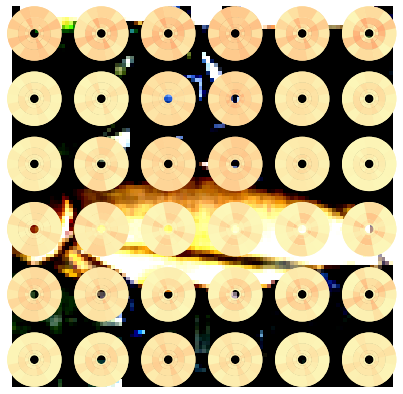

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


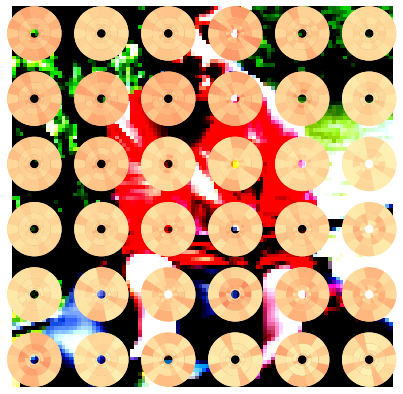

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


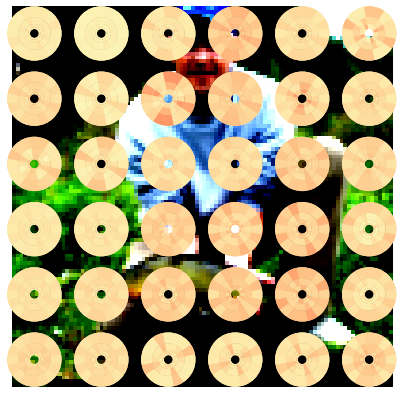

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


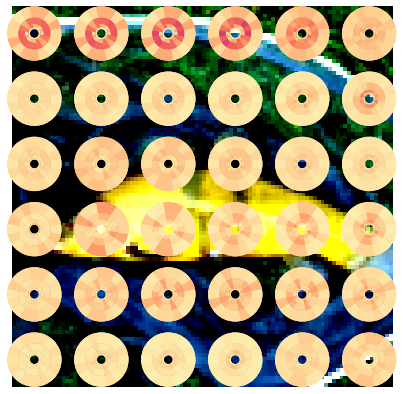

In [42]:
print(" -- NOTE : since the images are in RGB (3 axis), the scattering rings plotted are the mean of the 3 axis !")

imgs, labels = next(iter(loader))

nsamples = 5

for i in range(nsamples):
    draw_scattering_coef(torch.transpose(torch.transpose(imgs[i, :, :, :], 0, 2), 0, 1),
                         scattering_coefficients[i].mean(axis=0), scattering_J, scat_angles, scattering_nphases)

In [43]:
out_scat = model.scattering(input_test.cuda())

In [44]:
print(f"flatten is applied to the output of the scattering, thus we will have a tensor of size: ({n_examples}, {3*dim_3}, {input_test[0].size()[1]//2**scattering_J}, {input_test[0].size()[2]//2**scattering_J})")
out_scat.size()

flatten is applied to the output of the scattering, thus we will have a tensor of size: (10, 1539, 6, 6)


torch.Size([10, 1539, 6, 6])

### Linear Projection:

In [45]:
model.linear_proj

LinearProj(
  (standardization): Rescaling()
  (proj): Conv2d(1539, 256, kernel_size=(3, 3), stride=(1, 1), bias=False)
)

In [46]:
scat_stand = model.linear_proj.standardization(out_scat)

In [47]:
scat_stand.size()

torch.Size([10, 1539, 6, 6])

In [48]:
lin_out = model.linear_proj(out_scat)

* In this case, the linear projection is done using a conv2D layer 

In [49]:
lin_out.size()

torch.Size([10, 256, 6, 6])

In [50]:
linp_p = lin_out.view(-1,L_proj_size)[0,:].cpu().detach().numpy()

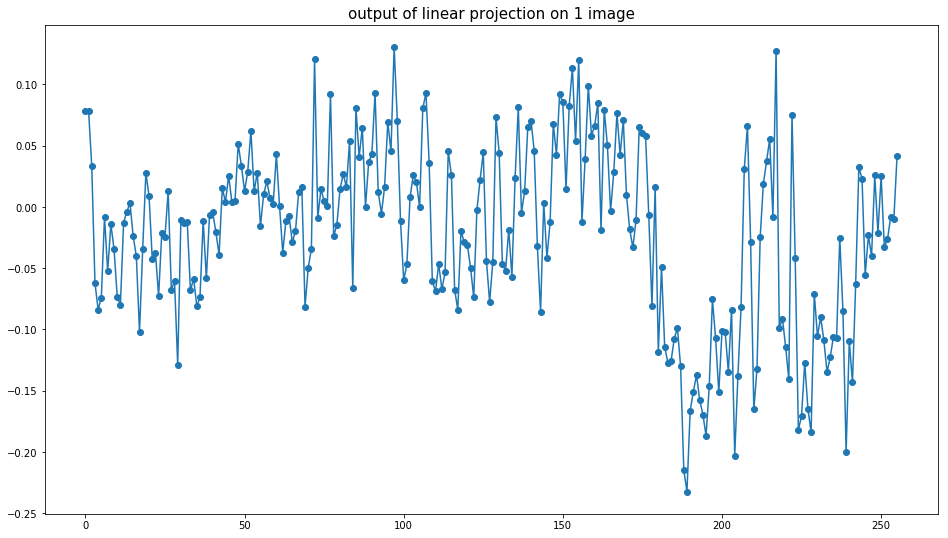

In [51]:
plt.figure(figsize=(16,9))
plt.plot(linp_p, "-o")
plt.title("output of linear projection on 1 image", fontsize=15)
plt.show()

### ISTC:

In [52]:
model.istc

ISTC()

In [53]:
istc_out = model.istc(lin_out)

In [54]:
istc_out.size()

torch.Size([10, 2048, 6, 6])

In [55]:
istc_arr = istc_out.view(-1,dictionary_size)[0,:].cpu().detach().numpy()

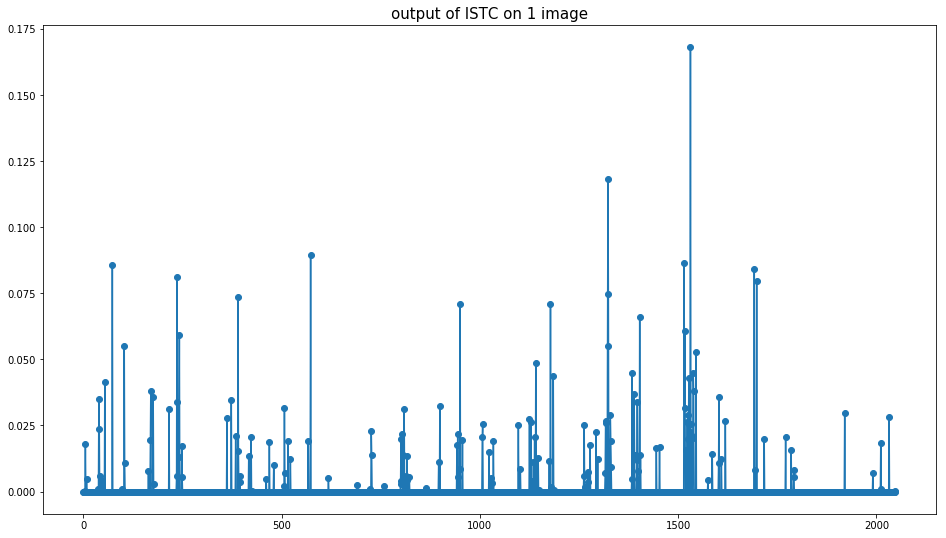

In [56]:
plt.figure(figsize=(16,9))
plt.plot(istc_arr, "-o")
plt.title("output of ISTC on 1 image", fontsize=15)
plt.show()

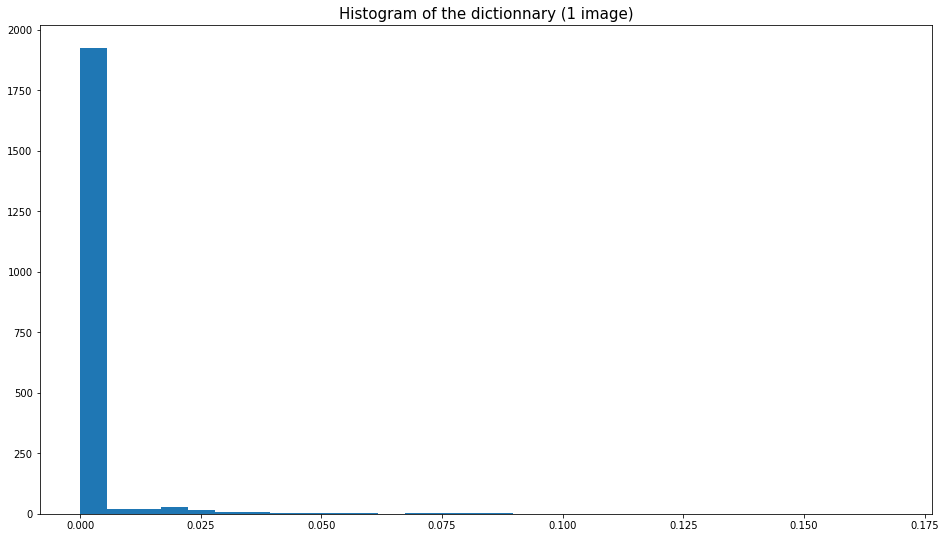

In [57]:
plt.figure(figsize=(16,9))
plt.hist(istc_arr, bins=30)
plt.title("Histogram of the dictionnary (1 image)", fontsize=15)
plt.show()

### Classifier:

In [58]:
out_scat.shape[2]

6

In [59]:
model.classifier

Classifier(
  (bn): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (classifier): Sequential(
    (0): Linear(in_features=32768, out_features=4096, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=4096, out_features=4096, bias=True)
    (4): ReLU(inplace=True)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=4096, out_features=1000, bias=True)
  )
)

In [60]:
n = out_scat.shape[2]  ### 6 for image size == 100
if avg_ker_size > 1:
    n += -avg_ker_size + 1

in_planes = nb_channels_in * (n ** 2)
print(f"The size of the first linear layer in mode.classifier.classifier is equal to {in_planes}")

The size of the first linear layer in mode.classifier.classifier is equal to 32768


In [61]:
clas_out = model.classifier(istc_out)

In [62]:
clas_out.size()

torch.Size([10, 1000])

In [63]:
avg_ker_size

3

In [64]:
torch.argmax(clas_out, dim=1)

tensor([111, 260, 260, 260, 111, 111, 111, 111, 111, 260], device='cuda:0')

# Dictionnary evolution during training

In [65]:
! ls checkpoints_sparsescatnet_100_class_dict_save/

dict_epoch_0.pth.tar   dict_epoch_32.pth.tar
dict_epoch_1.pth.tar   dict_epoch_33.pth.tar
dict_epoch_10.pth.tar  dict_epoch_34.pth.tar
dict_epoch_11.pth.tar  dict_epoch_35.pth.tar
dict_epoch_12.pth.tar  dict_epoch_36.pth.tar
dict_epoch_13.pth.tar  dict_epoch_37.pth.tar
dict_epoch_14.pth.tar  dict_epoch_38.pth.tar
dict_epoch_15.pth.tar  dict_epoch_39.pth.tar
dict_epoch_16.pth.tar  dict_epoch_4.pth.tar
dict_epoch_17.pth.tar  dict_epoch_40.pth.tar
dict_epoch_18.pth.tar  dict_epoch_41.pth.tar
dict_epoch_19.pth.tar  dict_epoch_42.pth.tar
dict_epoch_2.pth.tar   dict_epoch_43.pth.tar
dict_epoch_20.pth.tar  dict_epoch_44.pth.tar
dict_epoch_21.pth.tar  dict_epoch_45.pth.tar
dict_epoch_22.pth.tar  dict_epoch_46.pth.tar
dict_epoch_23.pth.tar  dict_epoch_47.pth.tar
dict_epoch_24.pth.tar  dict_epoch_48.pth.tar
dict_epoch_25.pth.tar  dict_epoch_49.pth.tar
dict_epoch_26.pth.tar  dict_epoch_5.pth.tar
dict_epoch_27.pth.tar  dict_epoch_6.pth.tar
dict_epoch_28.pth.tar  dict_epoch_7.pth.tar
dict_epoch_29.

In [78]:
list_dict = [torch.load(f"checkpoints_sparsescatnet_100_class_dict_save/dict_epoch_{i}.pth.tar")['dictionary'] for i in range(50)]
list_dict = [d.view(L_proj_size, dictionary_size).detach().cpu().numpy() for d in list_dict]

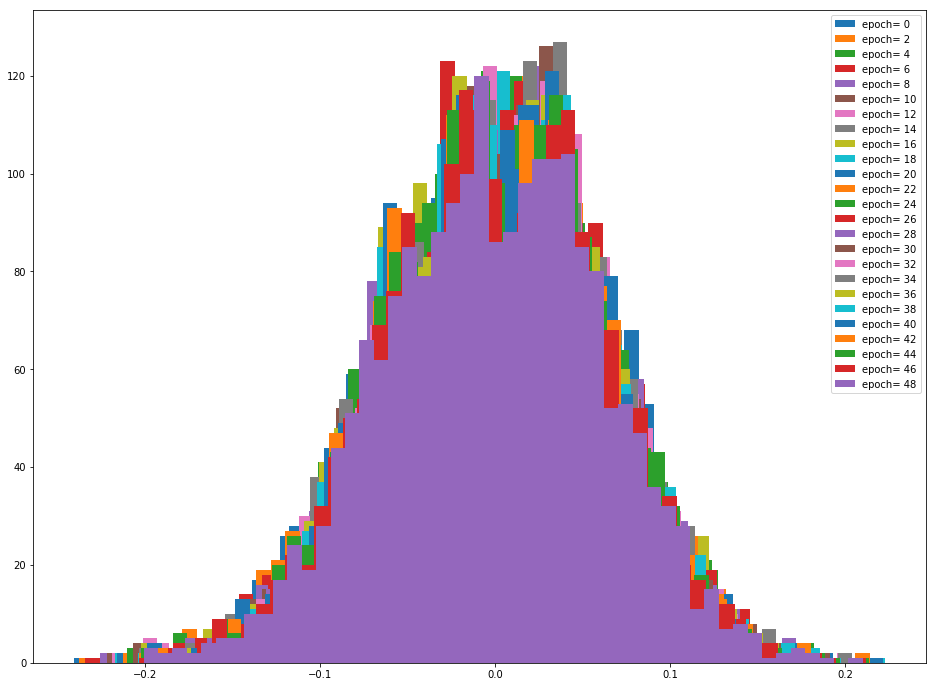

In [79]:
plt.figure(figsize=(16,12))
for i, d in enumerate(list_dict) : 
    if i%2 == 0 :
        plt.hist(d[1,:], label = f"epoch= {i}", bins=50)
plt.legend()
#plt.xlim((0,200))
plt.show()

In [80]:
dictionary_size

2048

In [95]:
row = 200

In [96]:
list_mean = [d[row,:].mean() for d in list_dict]

In [97]:
list_std  = [d[row,:].std() for d in list_dict]

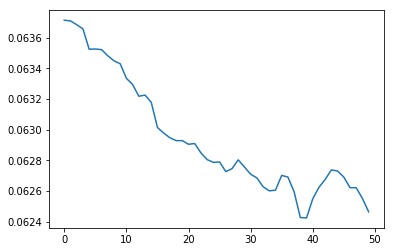

In [98]:
plt.figure()
plt.plot(list_std)
plt.show()

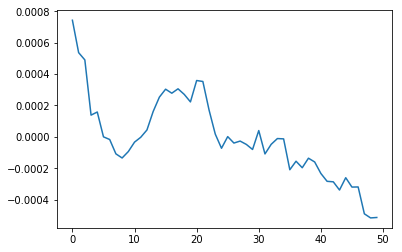

In [99]:
plt.figure()
plt.plot(list_mean)
plt.show()

In [114]:
global_count = 0
for e, d in enumerate(list_dict) :
    count = 0
    for i in range(dictionary_size):
        if (d[:,i]**2).sum() < 0.99 or (d[:,i]**2).sum() > 1.01:
                count += 1
                
    if count != 0 : 
        print("{} dictionary atoms not initially well normalized at epoch : {}".format(count, e))
        global_count += 1
if global_count == 0 : 
    print("all the atoms are well normalized :)")

all the atoms are well normalized :)


In [118]:
import pandas as pd 
import seaborn as sns

In [122]:
dict_data = {"mean" : [d[:,i].mean() for i in range(dictionary_size) for _, d in enumerate(list_dict)],
             "std"  : [d[:,i].std()  for i in range(dictionary_size) for _, d in enumerate(list_dict)], 
             "epoch": [e for _ in range(dictionary_size) for e, _ in enumerate(list_dict)]}

In [123]:
dataframe = pd.DataFrame(dict_data)

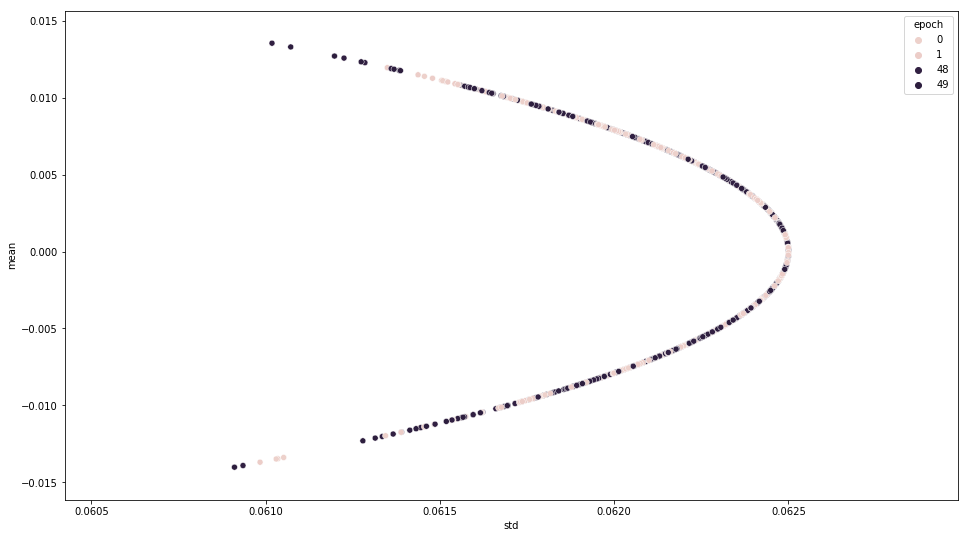

In [135]:
plt.figure(figsize=(16,9))
sns.scatterplot(data=dataframe[dataframe.epoch.isin([0,1,48,49])], x="std", y="mean", hue="epoch")
plt.show()

In [134]:
dataframe[dataframe.epoch.isin([0,1,48,49])]

,mean,std,epoch
0,0.004935,0.062305,0
1,0.005036,0.062297,1
48,0.003298,0.062413,48
49,0.003409,0.062407,49
50,0.000899,0.062494,0
...,...,...,...
102349,-0.004451,0.062341,49
102350,-0.004134,0.062363,0
102351,-0.004023,0.062370,1
102398,-0.005532,0.062255,48
